In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import confusion_matrix


## 1. Load the Iris data set

In [518]:
# import some data to play with
iris = datasets.load_iris()
X = iris.data[:,:3]
y = iris.target

In [299]:
iris.feature_names, iris.target_names

(['sepal length (cm)',
  'sepal width (cm)',
  'petal length (cm)',
  'petal width (cm)'],
 array(['setosa', 'versicolor', 'virginica'], dtype='<U10'))

In [300]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [301]:
# Building Random Forest model
model = RandomForestClassifier(random_state=123)
model.fit(X_train, y_train)
model.score(X_train, y_train), model.score(X_test, y_test)


(1.0, 0.9111111111111111)

In [302]:
y_pred=model.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[18,  0,  0],
       [ 0,  9,  1],
       [ 0,  3, 14]], dtype=int64)

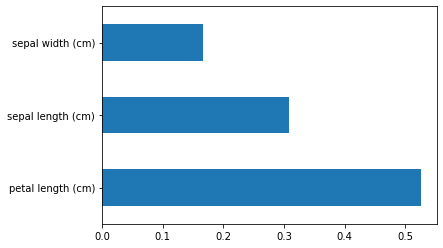

In [303]:
# Visualizing Feature Importance
feat_importances = pd.Series(model.feature_importances_, index=iris.feature_names[:3])
feat_importances.sort_values(ascending=False).plot(kind='barh')
plt.show()
#feat_importances.nlargest(len(feat_importances)).plot(kind='barh',figsize=(10,10))


## 2. Synthesize a variable with missing values


In [304]:
def setNA(data, col='sepal_length', p=0.2):
    data['var_withNA'] = data[col] 
    idx = np.random.choice(len(data), size=int(len(data)*p), replace=False)
    data['var_withNA'][idx]= np.nan
    data['NA_indicator'] = np.where(data.var_withNA.isna(),1,0)
    
    return data

In [305]:
data = pd.DataFrame(X, columns=['sepal_length','sepal_width', 'petal_length'])

In [306]:
iris.feature_names[:3]

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)']

In [323]:
col = 'petal_length'
data = setNA(data, col=col, p=0.4)
data.isna().sum()

<ipython-input-304-f6e97b736077>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['var_withNA'][idx]= np.nan


sepal_length     0
sepal_width      0
petal_length     0
var_withNA      60
NA_indicator     0
dtype: int64

In [324]:
data.isna().sum()

sepal_length     0
sepal_width      0
petal_length     0
var_withNA      60
NA_indicator     0
dtype: int64

## 3. Impute the missing values using

1. `SimpleImputer`:   
    a. Mean  
    b. Median  
    c. constant value = 0    
    
    
    
2. KNN imputation:  
`KNNImputer`


3. Multiple regression imputation:  

`IterativeImputer` performs multiple regressions on random samples of the data and aggregates for imputing the missing values.

In [325]:
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer

In [326]:
# explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer  
# now you can import normally from sklearn.impute
from sklearn.impute import IterativeImputer

In [327]:
data[col].describe()

count    150.000000
mean       3.758000
std        1.765298
min        1.000000
25%        1.600000
50%        4.350000
75%        5.100000
max        6.900000
Name: petal_length, dtype: float64

In [328]:
data_mean = data.drop(columns=[col, 'NA_indicator']).copy()
data_mean.iloc[:,:] = SimpleImputer(strategy='mean').fit_transform(data_mean)

In [329]:
data_median = data.drop(columns=[col, 'NA_indicator']).copy()
data_median.iloc[:,:] = SimpleImputer(strategy='median').fit_transform(data_median)

In [330]:
data_constant = data.drop(columns=[col, 'NA_indicator']).copy()
data_constant.iloc[:,:] = SimpleImputer(strategy='constant', fill_value=0).fit_transform(data_constant)

In [331]:
data_knn = data.drop(columns=[col, 'NA_indicator']).copy()
data_knn.iloc[:,:] = KNNImputer().fit_transform(data_knn)

In [332]:
data_reg = data.drop(columns=[col, 'NA_indicator']).copy()
data_reg.iloc[:,:] = IterativeImputer().fit_transform(data_reg)
data_reg.head(), data.head()

(   sepal_length  sepal_width  var_withNA
 0           5.1          3.5    1.400000
 1           4.9          3.0    2.246950
 2           4.7          3.2    1.300000
 3           4.6          3.1    1.595744
 4           5.0          3.6    1.614520,
    sepal_length  sepal_width  petal_length  var_withNA  NA_indicator
 0           5.1          3.5           1.4         1.4             0
 1           4.9          3.0           1.4         NaN             1
 2           4.7          3.2           1.3         1.3             0
 3           4.6          3.1           1.5         NaN             1
 4           5.0          3.6           1.4         NaN             1)

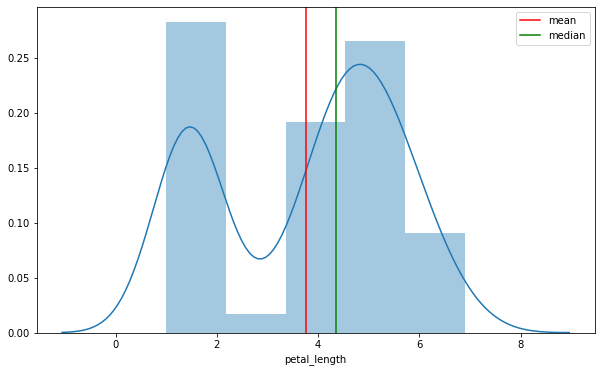

In [384]:
fig, ax = plt.subplots(figsize=(10,6))
sns.distplot(data[col])
plt.axvline(data[col].mean(), color='red', label='mean')
plt.axvline(data[col].median(), color='green', label='median')
plt.legend()
#sns.distplot(data_mean.var_withNA, label='mean imputation')
#sns.kdeplot(data_median.var_withNA, label='median imputation')
#sns.kdeplot(data_knn.var_withNA, label='KNN imputation', color='black')
#sns.kdeplot(data_reg.var_withNA, label='Regression imputation', color='green')
plt.show()

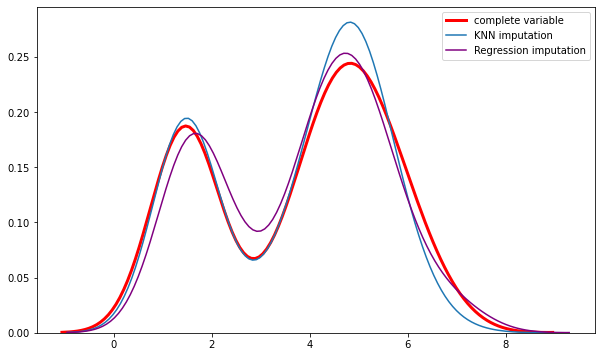

In [386]:
fig, ax = plt.subplots(figsize=(10,6))
sns.kdeplot(data[col], color='red', label='complete variable', linewidth=3)
#sns.kdeplot(data_mean.var_withNA, label='mean imputation')
#sns.kdeplot(data_median.var_withNA, label='median imputation')
sns.kdeplot(data_knn.var_withNA, label='KNN imputation')
sns.kdeplot(data_reg.var_withNA, label='Regression imputation', color='purple')
plt.show()

## 4. Using different imputation method in the ML model

In [519]:
y = iris.target
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2, 
                                                    stratify=data.NA_indicator, random_state=5)

In [520]:
X_train = X_train.drop(columns=[col, 'NA_indicator'])
X_test = X_test.drop(columns=[col, 'NA_indicator'])
X_train.isna().sum(), X_test.isna().sum()

(sepal_length     0
 sepal_width      0
 var_withNA      48
 dtype: int64,
 sepal_length     0
 sepal_width      0
 var_withNA      12
 dtype: int64)

In [556]:
X=data.drop(columns=[col, 'NA_indicator'])
X.shape

(150, 3)

In [522]:
#y = y[X.var_withNA.notna()]
#X = X.dropna()
#y.shape, X.shape

In [523]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

In [524]:
model1=Pipeline([('imputation', SimpleImputer(strategy='mean')),
                ('RF', RandomForestClassifier(random_state=123))])

model2=Pipeline([('imputation', SimpleImputer(strategy='median')),
                ('RF', RandomForestClassifier(random_state=123))])

model3=Pipeline([('imputation', SimpleImputer(strategy='constant', fill_value=0)),
                ('RF', RandomForestClassifier(random_state=123))])

model4=Pipeline([('imputation', KNNImputer()),
                ('RF', RandomForestClassifier(random_state=123))])

model5=Pipeline([('imputation', IterativeImputer(random_state=123)),
                ('RF', RandomForestClassifier(random_state=123))])

In [557]:
cv_results = []
for model in [model1, model2, model3, model4, model5]:
    cv_results.append(cross_val_score(model, X, y, scoring = "accuracy", cv = 5))

In [558]:
cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

In [559]:
cv_res = pd.DataFrame({'Algorithm': ['Mean imputation', 'Medium imputation', 'Constant imputation (0)',
                                    'KNN imputation', 'Multiple Regression imputation'],
                     'Accuracy_mean': cv_means, 
                     'Accuracy_std': cv_std})

In [560]:
cv_res.sort_values('Accuracy_mean', ascending=False)

,Algorithm,Accuracy_mean,Accuracy_std
3,KNN imputation,0.873333,0.057349
4,Multiple Regression imputation,0.866667,0.055777
1,Medium imputation,0.853333,0.054160
0,Mean imputation,0.846667,0.054160
2,Constant imputation (0),0.846667,0.074833


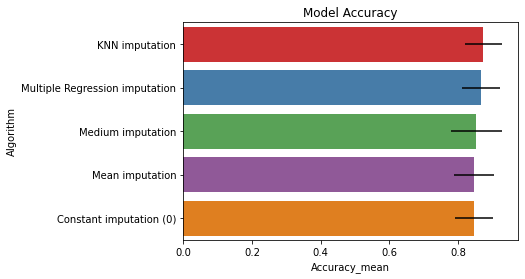

In [561]:
sns.barplot("Accuracy_mean", "Algorithm", data = cv_res.sort_values('Accuracy_mean', ascending=False), 
            palette="Set1", orient = "h", **{'xerr':cv_std})

plt.title("Model Accuracy")
plt.show()

In [554]:
cv_res_imputation.sort_values('Accuracy_mean', ascending=False)

,Algorithm,Accuracy_mean,Accuracy_std
3,KNN imputation,0.846667,0.191021
4,Multiple Regression imputation,0.846667,0.191021
0,Mean imputation,0.833333,0.191485
2,Constant imputation (0),0.833333,0.191485
1,Medium imputation,0.820000,0.202320


In [501]:
cv_res_twovars.sort_values('Accuracy_mean', ascending=False)

In [ ]:
0.72 to 0.91